# Feature Selection

### Support Functions

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# For importance_plotter
import matplotlib.patches as mpatches
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

# For correlation_plotter
from itertools import combinations
from sklearn.linear_model import LinearRegression
from tools.feature_format import featureFormat, targetFeatureSplit

# For make_features_labels
from tools.feature_format import featureFormat, targetFeatureSplit

def importance_plotter(features, labels, feature_names, balanced=False, threshold='mean'):
    """
    Makes a bar graph of feature importances based on ExtraTreesClassifier.
    Returns a list with the features selected to be above the importance mean.
    """
    if balanced:
        forest = ExtraTreesClassifier(n_estimators=500,
                                      random_state=0,
                                      class_weight='balanced')
    else:
        forest = ExtraTreesClassifier(n_estimators=500,
                                      random_state=0)
    forest.fit(features, labels)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    name_array = np.array(feature_names)
    sorted_names = name_array[indices]

    model = SelectFromModel(forest, prefit=True, threshold=threshold)
    selected_indices = model.get_support()
    selected_names = name_array[selected_indices]

    # Plot the feature importances and which were selected
    plt.close('all')
    fig = plt.figure(1, figsize=(10, 7), tight_layout=True)
    ax = fig.gca(title='Feature selection based on ExtraTreesClassifier importances',
                 xlabel='Feature name',
                 xlim=[-1, features.shape[1]],
                 xticks=range(len(sorted_names)),
                 ylabel='Importance')
    bar_list = ax.bar(range(features.shape[1]), importances[indices],
                      color='b', yerr=std[indices], align='center')
    ax.set_xticklabels(sorted_names, rotation='45', ha='right')
    # color selected features red
    for i, name in enumerate(sorted_names):
        if name in selected_names:
            bar_list[i].set_color('r')
    # create custom legend
    red_patch = mpatches.Patch(color='red', label='Features selected')
    blue_patch = mpatches.Patch(color='blue', label='Features not selected')
    plt.legend(handles=[red_patch, blue_patch])
    plt.show()

    return list(selected_names)

def correlation_plotter(selected_names, my_dataset):
    reg = LinearRegression()
    scores = []

    for pair in combinations(selected_names, 2):
        pair_data = featureFormat(my_dataset, [pair[0], pair[1]])
        d1 = np.reshape(pair_data[:, 0], (len(pair_data[:, 0]), 1))
        d2 = np.reshape(pair_data[:, 1], (len(pair_data[:, 1]), 1))
        reg.fit(d1, d2)
        score = reg.score(d1, d2)
        scores.append((pair[0], pair[1], d1, d2, score))

    scores = sorted(scores, key=lambda score: score[4], reverse=True)
    top_scores = scores[:6]
    fig = plt.figure(2, figsize=(10, 7), tight_layout=True)
    for i, score in enumerate(top_scores):
        X = score[2]
        y = score[3]
        ax = fig.add_subplot(231+i)
        ax.scatter(X, y)
        ax.set_xlabel(score[0])
        ax.set_ylabel(score[1])
        title = 'R2: ' + str(round(score[4], 3))
        ax.set_title(title)
    plt.show()
    
def make_features_labels(dataset, feature_names):
    """
    Quick way to split a dataset into features and labels based on feature names
    """
    data = featureFormat(dataset, feature_names, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    labels = np.array(labels)
    features = np.array(features)
    
    return features, labels

In [22]:
# Load the dictionary containing financial data and some email features (to_ from_poi)
import pickle
with open('data/final_project_dataset.pkl', 'rb') as f:
    fin_data = pickle.load(f)

# Remove 'TOTAL' from data
del fin_data['TOTAL']

# Convert negative numbers in data to zero
count = 0
for key1, item in fin_data.items():
    for key2 in item.keys():
        if item[key2] < 0:
            item[key2] = 0
            count += 1
print '%i negative values changed to zero' % count

66 negative values changed to zero


### Select features to use based on their importance as estimated by an ExtraTreesClassifier

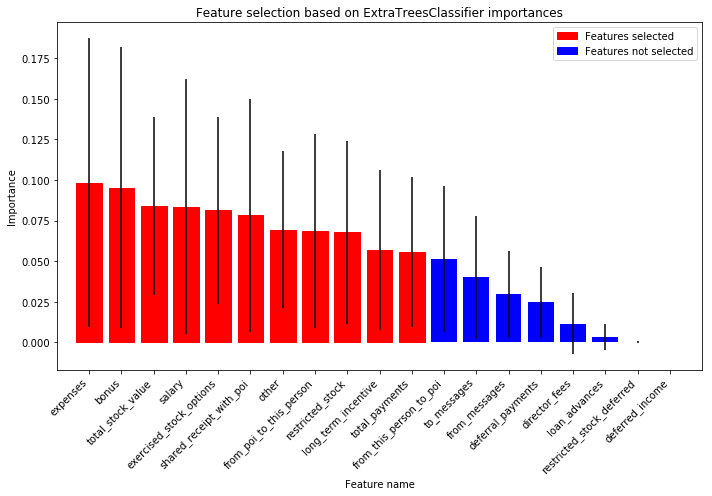

In [26]:
# features_list is a list of feature names in the financial data.
# The first feature must be "poi".
# Start with all features except: 'email_address'

all_feature_names = ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments',\
'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi',\
'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances',\
'from_messages', 'other', 'from_this_person_to_poi', 'director_fees', 'deferred_income',\
'long_term_incentive', 'from_poi_to_this_person']

all_features, all_labels = make_features_labels(fin_data, all_feature_names)

# Select the most important features based on ExtraTreesClassifier
selected_feature_names = importance_plotter(all_features, all_labels, 
                                            np.array(all_feature_names[1:]), 
                                            balanced=True,
                                            threshold='mean')

### Confirm that the feature selection did help performance:

In [27]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn import metrics

# Make features and labels based on the new selection
selected_feature_names.insert(0, 'poi')
selected_features, selected_labels = make_features_labels(fin_data, selected_feature_names)

clf = GaussianNB()
def fit_print_scores(clf, features, labels):
    splits = 100
    scores = ['f1', 'precision', 'recall']
    for score in scores:
        values = cross_val_score(clf, features, labels, cv=splits, scoring='%s_macro' % score)
        print '-%s score: %0.2f (+/- %0.2f)' % (score, 
                                               values.mean(), 
                                               values.std() * 2)

print 'All features:'
fit_print_scores(clf, all_features, all_labels)
print '\nSelected features:'
fit_print_scores(clf, selected_features, selected_labels)

All features:
-f1 score: 0.74 (+/- 0.79)
-precision score: 0.74 (+/- 0.80)
-recall score: 0.76 (+/- 0.78)

Selected features:
-f1 score: 0.86 (+/- 0.59)
-precision score: 0.85 (+/- 0.62)
-recall score: 0.87 (+/- 0.56)


### Plot the most highly correlated features to see if there is any redundancy or outliers 

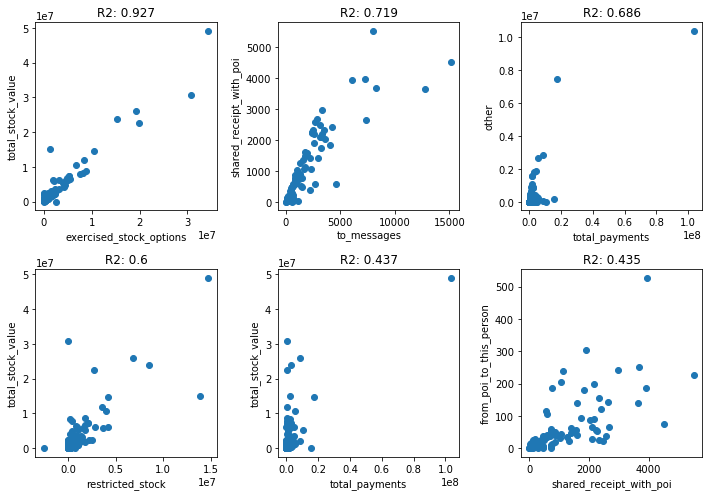

In [21]:
correlation_plotter(selected_feature_names[1:], fin_data)

The correlation graphs show there is a redundancy between total_stock_value and exercised_stock_options. I will not include exercised_stock_options in the feature selection.
There is also a negative outlier in the restricted stock data. Will convert that point to 0. 

In [8]:
outlier_key = [key for key, item in fin_data.items() if item['restricted_stock'] < 0]
print 'Outlier keys BEFORE removal: ', len(outlier_key)
fin_data[outlier_key[0]]['restricted_stock'] = 0
outlier_key = [key for key, item in fin_data.items() if item['restricted_stock'] < 0]
print 'Outlier keys AFTER removal: ', len(outlier_key)
selected_feature_names.remove('restricted_stock')
selected_feature_names

Outlier keys BEFORE removal:  1
Outlier keys AFTER removal:  0


['poi',
 'salary',
 'exercised_stock_options',
 'bonus',
 'shared_receipt_with_poi',
 'total_stock_value',
 'expenses',
 'other',
 'deferred_income',
 'from_poi_to_this_person']